In [3]:
import numpy as np
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt

df = pd.read_json("../data/preprocessed/research.jsonl", lines=True, nrows=1000)

## Tuning the Semantic Chunker

Goal: find the semantic chunker settings that will most accurately chunk research papers to **paragraphs**

Methodology: 
1. Pick 3 random papers
2. Using their original papers, identify the paragraph boundaries
3. Grid Search over SemanticChunker parameters to find the one that most aligns with paragraph chunking

In [7]:
np.random.seed(1)
sample_df = df.sample(3)
sample_df

,bibcode,abstract,aff,author,bibstem,doctype,doi,id,pubdate,title,read_count,reference,data,citation_count,citation,body,dois,keywords,loaded_from,body_sentences
507,2007MNRAS.379.1599L,"We describe the goals, design, implementation,...","[Institute for Astronomy, SUPA (Scottish Unive...","[Lawrence, A., Warren, S. J., Almaini, O., Edg...","[MNRAS, MNRAS.379]",article,10.1111/j.1365-2966.2007.12040.x,2344762,2007-08-01,The UKIRT Infrared Deep Sky Survey (UKIDSS),99,"[1973asqu.book.....A, 1983ApJ...264..337S, 198...","[CDS:3, IRSA:1, SIMBAD:22]",2215,"[2006MNRAS.371.1722D, 2006MNRAS.372..357M, 200...",1 INTRODUCTION The UKIRT Infrared Deep Sky Sur...,"[10.1111/j.1365-2966.2007.12040.x, 10.48550/ar...","[surveys, infrared: general, Astrophysics]",data/json/Astro_Research.json,[1 INTRODUCTION The UKIRT Infrared Deep Sky Su...
818,1994MNRAS.271..676L,We have made a detailed comparison of the resu...,"[-, -]","[Lacey, C., Cole, S.]","[MNRAS, MNRAS.271]",article,10.1093/mnras/271.3.676,3121109,1994-12-01,Merger Rates in Hierarchical Models of Galaxy ...,46,"[1974ApJ...187..425P, 1977ApJS...34..425D, 197...",None,678,"[1994MNRAS.271..781C, 1994astro.ph.12088M, 199...",19 94MNRAS.271. .676L Mon. Not. R. Astron. Soc...,"[10.1093/mnras/271.3.676, 10.48550/arXiv.astro...",[Astrophysics],data/json/Astro_Research.json,[19 94MNRAS.271. .676L Mon. Not. R. Astron....
452,2020ApJ...900..179K,To reach a deeper understanding of the origin ...,"[Centre for Astrophysics Research, Department ...","[Kobayashi, Chiaki, Karakas, Amanda I., Lugaro...","[ApJ, ApJ...900]",article,10.3847/1538-4357/abae65,19402707,2020-09-01,The Origin of Elements from Carbon to Uranium,274,"[1955ApJ...121..161S, 1957RvMP...29..547B, 196...",[SIMBAD:17],490,"[2020A&A...642A..62A, 2020A&A...643A..49H, 202...",1. Introduction Since the time of Burbidge et ...,"[10.3847/1538-4357/abae65, 10.48550/arXiv.2008...","[Galaxy abundances, Stellar abundances, Chemic...",data/json/Astro_Research.json,[1. Introduction Since the time of Burbidge et...


## Preprocessing

1. Get all the first sentences of each paragraph / section
1. Ensure the sentence strings appear in the body of each paper **exactly**
1. Ensure the sentence strings appear in order wrt the body text on file (some papers jumble sections after OCR)

It was discovered that the Ukirt paper's encoding in the dataset contained an error: the paper body was stored twice (meaning the body text was stored then concatenated with itself). The true body is 86621 chars long, so we will manually truncate this in order to configure the chunking correctly.

In [8]:
# Get the actual index label of the first row in the sample
row_index = sample_df.index[0]

# Now use .loc with the index label and column name
sample_df.loc[row_index, "body"] = sample_df.loc[row_index, "body"][:86620]  # Use .loc for setting

print(len(sample_df.loc[row_index, "body"]))  # Verify using .loc as well

86620


In [9]:
from first_paragraph_sentences import ukirt, lacey, kobayashi

def get_truncated_sentences(lst: list[str], max_length: int = 75) -> list:
    return [sentence[:max_length] for sentence in lst]

first_paragraph_sentences = [
    get_truncated_sentences(ukirt),
    get_truncated_sentences(lacey),
    get_truncated_sentences(kobayashi)
]

def are_sentences_in_body(idx) -> bool:
    """
    Check if all sentences in the list are present in the body of the text.
    """
    sentences = first_paragraph_sentences[idx]
    paper_body = sample_df.iloc[idx]['body']
    all_there = True
    for i, sentence in enumerate(sentences):
        if sentence not in paper_body:
            print(f"Sentence {i} not found: {sentence}")
            all_there = False
    return all_there

for i in range(3):
    print(f"[Paper {i}] all paragraph sentences are in the paper body: {are_sentences_in_body(i)}")

    

[Paper 0] all paragraph sentences are in the paper body: True
[Paper 1] all paragraph sentences are in the paper body: True
[Paper 2] all paragraph sentences are in the paper body: True


In [10]:
sentence_indices = []
for i in range(3):
    sentences = first_paragraph_sentences[i]
    paper_body = sample_df.iloc[i]['body']
    sentence_indices.append([paper_body.index(sentence) for sentence in sentences])
print(f"Sentence indices: {sentence_indices}")

Sentence indices: [[0, 1518, 2433, 3474, 4807, 5572, 6128, 6581, 7032, 7492, 8671, 9511, 10355, 11150, 11539, 12795, 13083, 14451, 15190, 15713, 17247, 18497, 20756, 21155, 22092, 22695, 24036, 25058, 25420, 27316, 28635, 29299, 29471, 29834, 31209, 32980, 33903, 35312, 35545, 36620, 37913, 38559, 39634, 39750, 41115, 41547, 42333, 45087, 45358, 45857, 45963, 47115, 47314, 48104, 48556, 49693, 50098, 51077, 51793, 52202, 52793, 54029, 55336, 55892, 56568, 57092, 57640, 58888, 59737, 60862, 61401, 61684, 62789, 63205, 63782, 64646, 65845, 66166, 67143, 67920, 68992, 69850, 70443, 70930, 71435, 71584, 72859, 73520, 74424, 75058, 75665, 76049, 76453, 77503, 78061, 79440, 80209, 81690, 82623, 83937, 85140, 86232], [0, 2355, 4217, 7240, 7796, 8573, 10416, 11689, 12200, 12967, 13461, 13992, 15168, 15423, 16484, 18438, 19409, 19653, 20356, 22039, 23560, 24007, 24469, 26148, 26857, 28526, 30410, 31334, 33231, 34643, 35568, 36348, 37572, 38863, 39252, 39948, 42920, 44474, 45196, 47027, 49634, 5

In [11]:
# Confirm the sentences are all in order
all_in_order = True
for i in range(3):
    sent_idx_list = sentence_indices[i]
    for j in range(1, len(sent_idx_list)):
        if sent_idx_list[j] <= sent_idx_list[j - 1]:
            print(f"Paper {i} Sentence {j} is out of order in paper {i}: {sent_idx_list}")
            print(f"  Index of sentence {j}: {sent_idx_list[j]}")
            print(f"  Index of sentence {j-1}: {sent_idx_list[j-1]}")
            all_in_order = False

if all_in_order:
    print("All sentences are in order.")
            

All sentences are in order.


## Computing Boundary Similarities

1. Package the vetted paragraph start sentences as reference lists
1. Create a grid over SemanticChunker parameters for search
1. For each parameter config, compare SemanticChunker boundary similarity to 

In [12]:

reference_lengths = []
for i in range(3):
    # Compute all the paragraph lengths
    idx_list = sentence_indices[i]
    paragraph_lengths = [
        idx_list[j] - idx_list[j - 1] for j in range(1, len(idx_list))
    ]

    # Add the last paragraph length
    paragraph_lengths.append(len(sample_df.iloc[i]['body']) - idx_list[-1])
    reference_lengths.append(paragraph_lengths)

print(f"Reference lengths: {reference_lengths}")
for i in range(3):
    print(f"Paper {i} min length: {min(reference_lengths[i])}, total length: {sum(reference_lengths[i])}, original body length: {len(sample_df.iloc[i]['body'])}")
    assert sum(reference_lengths[i]) == len(sample_df.iloc[i]['body']), f"Paper {i} length mismatch: {sum(reference_lengths[i])} != {len(sample_df.iloc[i]['body'])}"



Reference lengths: [[1518, 915, 1041, 1333, 765, 556, 453, 451, 460, 1179, 840, 844, 795, 389, 1256, 288, 1368, 739, 523, 1534, 1250, 2259, 399, 937, 603, 1341, 1022, 362, 1896, 1319, 664, 172, 363, 1375, 1771, 923, 1409, 233, 1075, 1293, 646, 1075, 116, 1365, 432, 786, 2754, 271, 499, 106, 1152, 199, 790, 452, 1137, 405, 979, 716, 409, 591, 1236, 1307, 556, 676, 524, 548, 1248, 849, 1125, 539, 283, 1105, 416, 577, 864, 1199, 321, 977, 777, 1072, 858, 593, 487, 505, 149, 1275, 661, 904, 634, 607, 384, 404, 1050, 558, 1379, 769, 1481, 933, 1314, 1203, 1092, 388], [2355, 1862, 3023, 556, 777, 1843, 1273, 511, 767, 494, 531, 1176, 255, 1061, 1954, 971, 244, 703, 1683, 1521, 447, 462, 1679, 709, 1669, 1884, 924, 1897, 1412, 925, 780, 1224, 1291, 389, 696, 2972, 1554, 722, 1831, 2607, 554, 2797, 1351, 1277, 499, 642, 1257, 1083, 764, 2374, 1233, 1159, 1916, 1169, 1055, 4311], [1125, 933, 1683, 1628, 769, 1068, 1188, 1719, 294, 1133, 919, 918, 1750, 1317, 368, 939, 512, 699, 1088, 442, 733, 

In [37]:
print(reference_lengths[2].index(10695))
print(sentence_indices[2][60:62])
print(kobayashi[60:62])

60
[59027, 69722]
['3.2. Elemental Abundances from C to Zn Based on our fiducial model', 'The contribution to GCE from AGB stars (green dotted lines in Figure 5 ) can be seen mainly for C and N, and only slightly for Na, compared with the model that includes supernovae only (blue dashed lines).']


In [ ]:
from segeval import boundary_similarity
from langchain_experimental.text_splitter import SemanticChunker
from langchain_huggingface import HuggingFaceEmbeddings
import torch

# Usage
# model_name = "bert-base-uncased"
# hf_embeddings = HuggingFaceEmbeddings(
#     model_name=model_name,
#     model_kwargs={"device": "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"},
#     encode_kwargs={"normalize_embeddings": False},
# )

No sentence-transformers model found with name bert-base-uncased. Creating a new one with mean pooling.


In [ ]:
import re
class LengthPreservingChunker(SemanticChunker):
    def __init__(
        self,
        embeddings,
        buffer_size: int = 1,
        breakpoint_threshold_type: str = "percentile",
        breakpoint_threshold_amount: float = 95,
        number_of_chunks: int = None,
        sentence_split_regex: str = r"(?<=[.?!]\s)(?=\S)",
        min_chunk_size: int = 64,
    ):
        super().__init__(
            embeddings=embeddings,
            buffer_size=buffer_size,
            breakpoint_threshold_type=breakpoint_threshold_type,
            breakpoint_threshold_amount=breakpoint_threshold_amount,
            number_of_chunks=number_of_chunks,
            sentence_split_regex=sentence_split_regex,
            min_chunk_size=min_chunk_size,
        )
        # Warn user if regex consumes chars
        zero_width_pattern = re.compile(
            r"""^(?:
            \(\?<=[^)]*\)   # positive lookbehind
            | \(\?<![^)]*\)   # negative lookbehind
            | \(\?=[^)]*\)    # positive lookahead
            | \(\?![^)]*\)    # negative lookahead
            | [\^$]           # start/end anchors
            | \\[bBAZz]       # \b, \B, \A, \Z, \z
            )*$""",
            re.VERBOSE
        )
        if not zero_width_pattern.match(sentence_split_regex):
            print(
                "Warning: The sentence_split_regex pattern may consume characters. "
                "This may modify total text length after splitting text."
            )

    def split_text(self, text: str) -> list[str]:
        # Warn user if regex consumes chars

        single_sentences = re.split(self.sentence_split_regex, text)
        # 2. everything else the same up through finding breakpoints...
        distances, sentences = self._calculate_sentence_distances(single_sentences)
        if self.number_of_chunks is None:
            threshold, dist_array = self._calculate_breakpoint_threshold(distances)
        else:
            threshold = self._threshold_from_clusters(distances)
            dist_array = distances

        breakpoints = {i for i, d in enumerate(dist_array) if d > threshold}

        # 3. build your chunks **without** injecting extra spaces
        chunks = []
        start = 0
        for bp in sorted(breakpoints):
            group = sentences[start : bp + 1]
            # ← ← ← here’s the only change
            combined = "".join(d["sentence"] for d in group)
            chunks.append(combined)
            start = bp + 1

        # last tail
        if start < len(sentences):
            tail = "".join(d["sentence"] for d in sentences[start:])
            chunks.append(tail)

        return chunks

Chunked length: 178503
Original length: 178503


In [ ]:
def evaluate_params(
        model_name: str,
        breakpoint_threshold_type: str,
        breakpoint_threshold_amount: float,
        min_chunk_size: int,):
    """
    Instantiates a chunker with the given parameters and evaluates its boundary similarity on the reference chunks
    """
    # Set up the chunker
    embeddings = HuggingFaceEmbeddings(
        model_name=model_name,
        model_kwargs={"device": "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"},
        encode_kwargs={"normalize_embeddings": False},
    )
    chunker = LengthPreservingChunker(
        embeddings=embeddings,
        breakpoint_threshold_type=breakpoint_threshold_type,
        breakpoint_threshold_amount=breakpoint_threshold_amount,
        min_chunk_size=min_chunk_size,  # in chars
    )

    scores = []
    for i in range(3):
        # Get the predicted chunks
        chunks = chunker.split_text(sample_df.iloc[i]['body'])
        chunk_lengths = [len(chunk) for chunk in chunks]

        # Compute the boundary similarity score
        score = boundary_similarity(reference_lengths[i], chunk_lengths)
        scores.append(float(score))
        print(f"[{model_name}]:({breakpoint_threshold_type}:{breakpoint_threshold_amount}), min chunk size {min_chunk_size}: {score}")
    print("=======")

    scores = [float(score) for score in scores]
    average_score = sum(scores) / len(scores)
    with open("data/etc/chunker_scores.csv", "a") as f:
        f.write(f"{model_name},{breakpoint_threshold_type},{breakpoint_threshold_amount},{min_chunk_size},{average_score},{scores}\n")
    return average_score



In [ ]:
MODELS = [
    # "all-MiniLM-L6-v2",
    # "bert-base-uncased",
    "adsabs/astroBERT",
    "BAAI/bge-large-en-v1.5",
    "nasa-impact/nasa-ibm-st.38m",
]
breakpoints = {
    "percentile": [n for n in range(1, 100, 3)],
    "gradient": [n for n in range(1, 100, 3)],
    "standard_deviation": [0.1 * n for n in range(1, 40)],
    "interquartile": [0.1 * n for n in range(1, 40)],
}
MIN_CHUNK_SIZES = [50, 100]

all_configs_kwargs = []

# Iterate through models
for model in MODELS:
    for bp_type, bp_amounts in breakpoints.items():
        for bp_amount in bp_amounts:
            for chunk_size in MIN_CHUNK_SIZES:
                # Create the kwargs dictionary
                config_kwargs = {
                    "model_name": model,
                    "breakpoint_threshold_type": bp_type,
                    "breakpoint_threshold_amount": bp_amount,
                    "min_chunk_size": chunk_size,
                }
                all_configs_kwargs.append(config_kwargs)

# Print the first few configurations to verify
print(f"Total configurations generated: {len(all_configs_kwargs)}")
print("First 3 configurations:")
pprint(all_configs_kwargs[:3])

Total configurations generated: 1440
First 3 configurations:
[{'breakpoint_threshold_amount': 1,
  'breakpoint_threshold_type': 'percentile',
  'min_chunk_size': 50,
  'model_name': 'all-MiniLM-L6-v2'},
 {'breakpoint_threshold_amount': 1,
  'breakpoint_threshold_type': 'percentile',
  'min_chunk_size': 100,
  'model_name': 'all-MiniLM-L6-v2'},
 {'breakpoint_threshold_amount': 4,
  'breakpoint_threshold_type': 'percentile',
  'min_chunk_size': 50,
  'model_name': 'all-MiniLM-L6-v2'}]


In [ ]:
for config in all_configs_kwargs:
    score = evaluate_params(**config)
    print(score)

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

[all-MiniLM-L6-v2]:(percentile:1), min chunk size 50: 0.05423728813559322033898305085
[all-MiniLM-L6-v2]:(percentile:1), min chunk size 50: 0.08623853211009174311926605505
[all-MiniLM-L6-v2]:(percentile:1), min chunk size 50: 0.09343434343434343434343434343
0.07797005456000948
[all-MiniLM-L6-v2]:(percentile:1), min chunk size 100: 0.05423728813559322033898305085
[all-MiniLM-L6-v2]:(percentile:1), min chunk size 100: 0.08623853211009174311926605505
[all-MiniLM-L6-v2]:(percentile:1), min chunk size 100: 0.09343434343434343434343434343
0.07797005456000948
[all-MiniLM-L6-v2]:(percentile:4), min chunk size 50: 0.05406976744186046511627906977
[all-MiniLM-L6-v2]:(percentile:4), min chunk size 50: 0.08679245283018867924528301887
[all-MiniLM-L6-v2]:(percentile:4), min chunk size 50: 0.09553903345724907063197026022
0.07880041790976607


In [50]:
results_df = pd.read_csv("data/etc/chunker_scores.csv")
results_df = results_df.drop_duplicates()
results_df = results_df.sort_values(by=["average_score"], ascending=False)
results_df.head()

,model_name,breakpoint_threshold_type,breakpoint_threshold_amount,min_chunk_size,average_score,score0,score1,score2
293,bert-base-uncased,percentile,7.0,100,0.079138,[0.052663076002393776,0.089494,0.09525631216526396]
292,bert-base-uncased,percentile,7.0,50,0.079138,[0.052663076002393776,0.089494,0.09525631216526396]
1155,nasa-impact/nasa-ibm-st.38m,percentile,4.0,100,0.079005,[0.054682955206515414,0.086792,0.09553903345724907]
1154,nasa-impact/nasa-ibm-st.38m,percentile,4.0,50,0.079005,[0.054682955206515414,0.086792,0.09553903345724907]
291,bert-base-uncased,percentile,4.0,100,0.078816,[0.05287623474723998,0.088847,0.09472511144130757]


In [51]:
from semantic_text_splitter import TextSplitter

# splitter = TextSplitter(capacity=1000, overlap=200)
splitter = TextSplitter((300, 1200), overlap=0)
chunks = splitter.chunks(sample_df.iloc[0]['body'])
print(f"Number of chunks: {len(chunks)}")

Number of chunks: 445


### Conclusion

The semantic chunker never exceeded 0.08 average boundary similarity. Perhaps we can do better by relying on the length

Total reference lengths: 294


(array([176.,  99.,  13.,   2.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([  106.  ,  1027.65,  1949.3 ,  2870.95,  3792.6 ,  4714.25,
         5635.9 ,  6557.55,  7479.2 ,  8400.85,  9322.5 , 10244.15,
        11165.8 , 12087.45, 13009.1 , 13930.75, 14852.4 , 15774.05,
        16695.7 , 17617.35, 18539.  , 19460.65, 20382.3 , 21303.95,
        22225.6 , 23147.25, 24068.9 , 24990.55

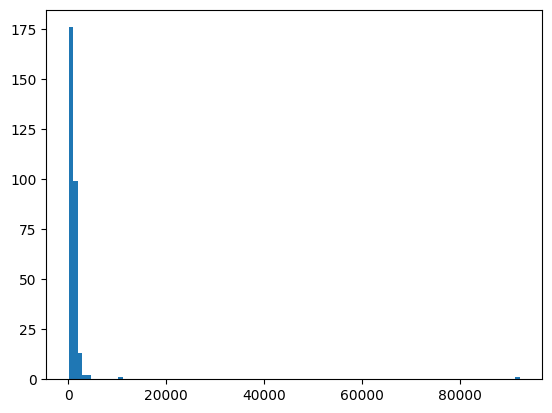

In [58]:
all_reference_lengths = [length for length_list in reference_lengths for length in length_list]
print(f"Total reference lengths: {len(all_reference_lengths)}")
np.mean(all_reference_lengths), np.std(all_reference_lengths)

import matplotlib.pyplot as plt

plt.hist(all_reference_lengths, bins=100)

In [72]:
reference_lengths[2][-1]

960

In [70]:
sentence_indices[0][-2:]

[85140, 86232]